# model

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import roc_auc_score

In [2]:
# knob 종류 및 바운드
knobs_rdb = {
    
    "hash-max-ziplist-entries":     (256, 751), 
    "hash-max-ziplist-value": (16, 257),
    "activerehashing": ('yes', 'no'),  ##yes
    "hz": (1, 41),
    "dynamic-hz": ('yes', 'no'),

    "save0_0": (700,1100),
    "save0_1": (1,9),
    "save1_0": (100,500),
    "save1_1": (10,100),
    "save2_0": (30,90),
    "save2_1": (8000,12000),

    "rdbcompression": ('yes', 'no'), ##yes
    "rdbchecksum": ('yes', 'no'),    ##yes
    "rdb-save-incremental-fsync": ('yes', 'no'),   ## yes

    "activedefrag": ('yes','no'),  
    "active-defrag-threshold-lower": (1, 31),
    "active-defrag-threshold-upper": (70, 101),
    "active-defrag-cycle-min": (1, 31),
    "active-defrag-cycle-max": (70, 91),
    
    "maxmemory": (1000, 2900),   ##"volatile-lru"
    "maxmemory-policy":     ("volatile-lru", "allkeys-lru", "volatile-lfu", "allkeys-lfu", 
                             "volatile-random","allkeys-random", "volatile-ttl", "noeviction"),
    "maxmemory-samples": (3, 7),
    
    "lazyfree-lazy-eviction": ('yes', 'no'),
    "lazyfree-lazy-expire": ('yes', 'no'),
    "lazyfree-lazy-server-del": ('yes', 'no')
}

knobs_list = list(knobs_rdb.keys())
knobs_bound = list(knobs_rdb.values())

## 데이터 전처리
* 이상치 파악
* test, train 데이터 잘 나뉘어졌는지 확인

In [3]:
# config(knob) data
config_df = pd.read_csv("../data/result_config_r10000_rdb.csv", sep=',')

# 1250 개 추출
config_df = config_df.iloc[0:1250,:]
config_df.shape

# external(throughput) data
# external_df = pd.read_csv("./data/external_metrics0.csv", sep=',')
external_df = pd.read_csv("../data/external_metrics_r10000_rdb.csv", sep=',')
# 1250 개 추출
external_df = external_df.iloc[0:1250,:]
external_df.shape

(1250, 32)

In [4]:
# config(knog), external(throughput) 데이터 하나의 프레임으로 결합
dataset = config_df
dataset['throughput'] = external_df['Gets_KB/sec']

In [5]:
# 결측치 처리 
dataset_nan = dataset.copy()
dataset['activedefrag'].fillna(value='no', inplace=True)  # activedefrag no 채우기
dataset = dataset.fillna(value = 0)  # 전부 0으로 채움

In [6]:
dataset.head(3)

,appendonly,appendfsync,auto-aof-rewrite-percentage,auto-aof-rewrite-min-size,no-appendfsync-on-rewrite,aof-rewrite-incremental-fsync,aof-use-rdb-preamble,save0_0,save0_1,save1_0,...,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,throughput
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1056,4,114,...,6,yes,no,no,615,232,no,23,no,52805.98
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,805,2,343,...,7,yes,no,no,496,156,yes,36,no,51890.64
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,776,6,194,...,5,no,yes,no,494,135,no,37,no,52373.84


In [7]:
# maxmemory knob 단위(mb) 처리
dataset['maxmemory']  = dataset['maxmemory'].str.strip('mb')
dataset['maxmemory'] = pd.to_numeric(dataset['maxmemory'])

In [8]:
# Object 변수 categorical 로 변경 (LightGBM에 바로 넣기 위해)
category_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'O':  # Object인 경우 category 형으로 변경
        dataset[knob] = dataset[knob].astype('category')
        if knob in knobs_list:
            category_knob.append(knob)

In [9]:
# 설정한 knob들만 추출
extract_knobs_list = knobs_list.copy()
extract_knobs_list.append('throughput')  # target 값 추가

dataset = dataset[extract_knobs_list]

In [10]:
# numeric_knob
numeric_knob = []

for knob in dataset:
    if dataset[knob].dtype == 'category':  # Object인 경우 category 형으로 변경
        continue
    numeric_knob.append(knob)

numeric_knob.remove('throughput')

In [11]:
dataset.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,activerehashing,hz,dynamic-hz,save0_0,save0_1,save1_0,save1_1,save2_0,...,active-defrag-threshold-upper,active-defrag-cycle-min,active-defrag-cycle-max,maxmemory,maxmemory-policy,maxmemory-samples,lazyfree-lazy-eviction,lazyfree-lazy-expire,lazyfree-lazy-server-del,throughput
0,615,232,no,23,no,1056,4,114,13,57,...,0.0,0.0,0.0,2000,volatile-lru,6,yes,no,no,52805.98
1,496,156,yes,36,no,805,2,343,23,47,...,0.0,0.0,0.0,1200,allkeys-lru,7,yes,no,no,51890.64
2,494,135,no,37,no,776,6,194,46,61,...,77.0,2.0,71.0,1800,volatile-random,5,no,yes,no,52373.84


### 이상치 처리

In [12]:
# 이상치 인덱스 반환 함수
def get_outlier(df=None, column=None, weight=1.5):
    
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

/Users/joseong-un/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='throughput'>

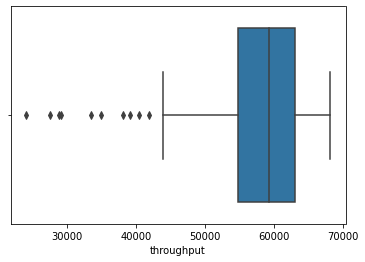

In [13]:
import seaborn as sns
sns.boxplot(dataset['throughput'])

In [14]:
# outlier_index = get_outlier(dataset, 'throughput')

# # 이상치 제거
# dataset.drop(outlier_index, axis=0, inplace = True)
# sns.boxplot(dataset['throughput'])

In [15]:
# 원핫인코딩
dataset_ohe = pd.get_dummies(dataset, columns = category_knob)
dataset_ohe.head(3)

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
0,615,232,23,1056,4,114,13,57,8497,0.0,...,0,1,1,0,1,0,1,0,1,0
1,496,156,36,805,2,343,23,47,8561,0.0,...,0,1,1,0,1,0,0,1,1,0
2,494,135,37,776,6,194,46,61,11337,30.0,...,1,0,0,1,1,0,1,0,1,0


In [16]:
dataset_ohe.drop(columns = ['throughput'])

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
0,615,232,23,1056,4,114,13,57,8497,0.0,...,0,1,1,0,1,0,1,0,1,0
1,496,156,36,805,2,343,23,47,8561,0.0,...,0,1,1,0,1,0,0,1,1,0
2,494,135,37,776,6,194,46,61,11337,30.0,...,1,0,0,1,1,0,1,0,1,0
3,491,76,16,742,9,295,59,57,8989,0.0,...,1,0,1,0,1,0,0,1,1,0
4,332,80,21,985,5,225,90,41,11978,0.0,...,0,1,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,623,244,8,851,5,121,84,79,11338,0.0,...,1,0,0,1,1,0,1,0,1,0
1246,363,34,37,825,8,443,19,49,10608,26.0,...,1,0,0,1,0,1,1,0,1,0
1247,572,229,10,908,7,255,88,64,8293,9.0,...,1,0,1,0,0,1,0,1,1,0
1248,375,32,38,1089,5,179,81,40,8054,28.0,...,0,1,0,1,1,0,1,0,0,1


In [17]:
# 원핫인코딩 반영 category_knob
category_knob_ohe = []

for ohe_category in dataset_ohe.columns.tolist():
    for origin_category in category_knob:
        if origin_category in ohe_category:
            category_knob_ohe.append(ohe_category)

### test, train 데이터 분리

In [18]:
#  정확도 확인용 train 8, test 2
X_train_val, X_test, y_train_val, y_test = train_test_split(dataset_ohe.drop(columns = ['throughput'])
                                                    , dataset_ohe['throughput'] 
                                                    ,test_size=0.2
                                                   , random_state = 156)

# train 8 val 2
X_train, X_val, y_train, y_val = train_test_split(X_train_val
                                                    , y_train_val 
                                                    ,test_size=0.2
                                                   , random_state = 156)


# # 전체 데이터 train 8, val 2
# X_train, X_val, y_train, y_val = train_test_split(dataset_ohe.drop(columns = ['throughput'])
#                                                     , dataset_ohe['throughput'] 
#                                                     ,test_size=0.2
#                                                    , random_state = 156)


In [19]:
# # scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X_train[numeric_knob])  # x_train 스케일 기준 정보 적용

# X_train_index = list(X_train.index)  # X_train 인덱스
# X_train_scaled_numeric = scaler.transform(X_train[numeric_knob])  # transformation
# X_train_scaled_numeric_df = pd.DataFrame(X_train_scaled_numeric, columns = numeric_knob, index = X_train_index)  
# X_train_scaled_df = pd.concat([X_train_scaled_numeric_df, X_train[category_knob_ohe]], axis=1)  # 카테고리와 합치기

# X_val_index = list(X_val.index)  # X_val 인덱스
# X_val_scaled_numeric = scaler.transform(X_val[numeric_knob])  # transformation
# X_val_scaled_numeric_df = pd.DataFrame(X_val_scaled_numeric, columns = numeric_knob, index = X_val_index)  
# X_val_scaled_df = pd.concat([X_val_scaled_numeric_df, X_val[category_knob_ohe]], axis=1)  # 카테고리와 합치기

In [20]:
# knob 리스트 인덱스 수정
knobs_list = X_train.columns.tolist()
# knobs_bound = list(knobs_rdb.values())

In [21]:
# # test, train 에 비슷하게 분류됬는지 확인
# y_train.hist()
# plt.title('train data')
# plt.show()

# y_test.hist()
# plt.title('test data')
# plt.show()

## XGBoost 모델 생성

In [22]:
from xgboost import XGBRegressor

# 모델 객체 생성, n_estimators = 400으로 설정
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.1)

# 검증 데이터(validation data)
evals = [(X_val.values, y_val.values)]

xgb_reg.fit(X_train.values, y_train.values, early_stopping_rounds=100, 
                eval_set = evals, verbose = True)


[0]	validation_0-rmse:53328.75000
[1]	validation_0-rmse:48080.05469
[2]	validation_0-rmse:43361.85547
[3]	validation_0-rmse:39121.83203
[4]	validation_0-rmse:35312.92578
[5]	validation_0-rmse:31892.86914
[6]	validation_0-rmse:28823.66211
[7]	validation_0-rmse:26071.16797
[8]	validation_0-rmse:23604.71875
[9]	validation_0-rmse:21396.76758
[10]	validation_0-rmse:19421.54102
[11]	validation_0-rmse:17652.24609
[12]	validation_0-rmse:16080.05859
[13]	validation_0-rmse:14694.03125
[14]	validation_0-rmse:13460.66113
[15]	validation_0-rmse:12386.42383
[16]	validation_0-rmse:11410.91699
[17]	validation_0-rmse:10572.04688
[18]	validation_0-rmse:9863.02832
[19]	validation_0-rmse:9218.11523
[20]	validation_0-rmse:8664.74121
[21]	validation_0-rmse:8162.03027
[22]	validation_0-rmse:7747.35596
[23]	validation_0-rmse:7386.79834
[24]	validation_0-rmse:7094.78516
[25]	validation_0-rmse:6850.61230
[26]	validation_0-rmse:6656.06543
[27]	validation_0-rmse:6469.08350
[28]	validation_0-rmse:6300.17969
[29]	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 성능 평가

In [23]:
# 성능 측정 함수 RMSLE(캐글에서 요구한 성능 평가 방법), MSE, RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산 
def rmsle(y, pred):
    # log1p 변환
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    # squred 계산
    squared_error = (log_y-log_pred)**2
    
    # RMSE 계산
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
    # MAE는 사이킷런의 mean_absolute_error()로 계산
    mae_val = mean_absolute_error(y, pred)
    
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    

In [24]:
# preds = xgb_reg.predict(X_test)  # 예측 결과
# evaluate_regr(y_test, preds)

이상치 제거 전 RMSLE: 0.060, RMSE: 3492.223, MAE: 3032.843

이상치 제거 후 RMSLE: 0.058, RMSE: 3393.720, MAE: 2974.377

In [25]:
X_test.iloc[:1,:]

,hash-max-ziplist-entries,hash-max-ziplist-value,hz,save0_0,save0_1,save1_0,save1_1,save2_0,save2_1,active-defrag-threshold-lower,...,lazyfree-lazy-eviction_no,lazyfree-lazy-eviction_yes,lazyfree-lazy-expire_no,lazyfree-lazy-expire_yes,lazyfree-lazy-server-del_no,lazyfree-lazy-server-del_yes,activerehashing_no,activerehashing_yes,dynamic-hz_no,dynamic-hz_yes
108,317,145,33,777,7,414,10,78,8216,8.0,...,1,0,1,0,1,0,0,1,1,0


In [26]:
# lgbm_wrapper.predict(X_test.iloc[3:4,:])

디폴트: 44428.73653257356

전체 BO 결과: 44791.058093691274

In [27]:
# df_result_test2

In [28]:
# lgbm_wrapper.predict(df_result_test2)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

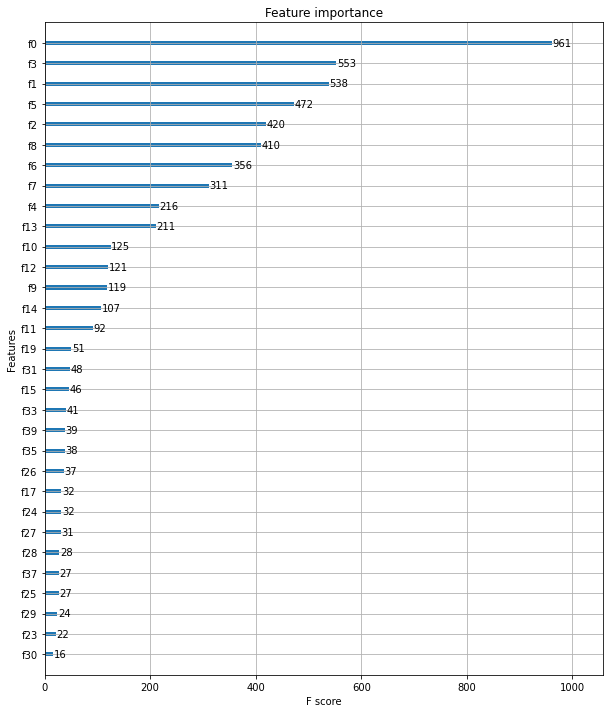

In [29]:
# plot_importance()를 이영해 피처 중요도 시각화
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_reg, ax= ax)

---

# BO

모델은 같은 것을 사용한다.

knob_default 딕셔너리 


1. 목적함수에서 지정한 범위knob 값을 랜덤하게 추출
2. 목적함수에는 init_knob 값이 지정되어있고 나머지 값들은 들어오는 값으로 초기화
목적함수 들어가기 전에 미리 선택을 해야 한다. 범위에 대해서 

cluster0 값만준다.
목적함수에서는 받은 cluster0을 할당한다
할당되지 않은 Knob에 대해서는 knob_init를 참고하여 값을 할당한다. 

결과값을 init_dict에 할당한다. 
목적함세어는 받은 cluster1을 할당한다.
할당되지 않은 Knob에 대해서는 knob_init을 참고한다. 




In [35]:
def knob_to_dict(knob_dict):
    for key, val in knob_dict.items():
                
        if 'yes' in key:
            if val == 0:
                continue
            elif val == 1:
                print(key[:-4], end=' ')
                print('yes')
                continue
        elif 'no' in key:
            if val == 0:
                continue
            elif val == 1:
                print(key[:-3], end=' ')
                print('no')
                continue        
        
        if 'save' in key:
            if key[6] == '0':
                print('save', end=' ')
                print(val, end=' ')
            elif key[6] == '1':
                print(val)
            continue
        
        if 'maxmemory' in key:
            if 'policy' in key:
                if val == 1:
                    print('maxmemory-policy', end=' ')
                    print(key[17:])
                    continue
                
                elif val == 0:
                    continue
            
            elif len(key) == 9:
                print(key, end=' ')
                print(val, end='')
                print('mb')
                continue                        
                
        print(key, end=' ')
        print(val)

def knob_to_dict2(knob_dict):
    for key, val in knob_dict.items():
                        
        if 'save' in key:
            if key == 'rdb-save-incremental-fsync':
                print(key, end=' ')
                print(val)
                continue
            
            if key[6] == '0':
                print('save', end=' ')
                print(val, end=' ')
            elif key[6] == '1':
                print(val)
            continue
        
        if key == 'maxmemory':
            print(key, end=' ')
            print(val,end='')
            print('mb')
            continue
                        
        print(key, end=' ')
        print(val)


## 목적함수

In [32]:
noise_level = 0.1

def objective_func(knob_value, noise_level=noise_level):

    knob_dict = {}
    for knob in knobs_list: # 순서에 맞게 선언
        knob_dict[knob] = 'x'
    
#     print('###x 삽입###')
#     print(knob_dict)
    
    # knob_value 값 먼저 할당, knobs에 클러스터 이름 들어있다. 
    for idx,knob in enumerate(knobs):
        # 범주형 변수 처리
        if knob in category_knob:
            if knob_value[idx] == 'no':
                knob_dict[knob+'_no'] = 1
                knob_dict[knob+'_yes'] = 0
                
            elif knob_value[idx] == 'yes':
                knob_dict[knob+'_no'] = 0
                knob_dict[knob+'_yes'] = 1
            else:  # maxmemory-policy
                mmp_list = [
                        'maxmemory-policy_allkeys-lfu', 
                        'maxmemory-policy_allkeys-lru',
                        'maxmemory-policy_allkeys-random', 
                        'maxmemory-policy_noeviction',
                        'maxmemory-policy_volatile-lfu', 
                        'maxmemory-policy_volatile-lru',
                        'maxmemory-policy_volatile-random', 
                        'maxmemory-policy_volatile-ttl',
                ]
                mmp_list.remove(knob+'_'+knob_value[idx])
                knob_dict[knob+'_'+knob_value[idx]] = 1
                
                for mmp in mmp_list:
                    knob_dict[mmp] = 0
            continue
            
        # 수치형 변수는 할당    
        knob_dict[knob] = knob_value[idx]
    

    
#     print('##먼저할당##')
#     print(knob_dict)
    
    
    # 나머지 값 채우기 
    for knob ,knob_val in knob_dict.items():
        if knob_val == 'x':
            knob_dict[knob] = knobs_update[knob]
            
#     print('##나머지 update 반영 할당##')
#     print(knob_dict)
                    
    if 'activedefrag' in knob_dict:
        if knob_dict['activedefrag'] == 'no':  # activedefrag no인 경우 나머지 관련 knob들에 0할당!
            activ_var = ['active-defrag-threshold-lower', 'active-defrag-threshold-upper', 'active-defrag-cycle-min', 'active-defrag-cycle-max']
            for activ_knob in activ_var:
                knob_dict[activ_knob] = 0
    
    knob_df = pd.DataFrame(knob_dict, index=[0])  # 데이터 프레임으로 변환
    
    return -xgb_reg.predict(knob_df.values)[0]


## gp_minimize

In [31]:
%matplotlib inline
print(__doc__)

import numpy as np
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

Automatically created module for IPython interactive environment


In [73]:
# knob 종류 및 바운드

cluster_table = {
    'clsuter0':[        
        'save0_0',
        'save0_1', 
        'save1_1',
        'maxmemory-samples',
        'hash-max-ziplist-value',
        
        'rdbcompression',
        'lazyfree-lazy-expire',
        'lazyfree-lazy-server-del',
        
        'dynamic-hz',
        'activerehashing',
    ],
    'cluster1':[
        
        'active-defrag-cycle-min',
        'active-defrag-cycle-max',
        'active-defrag-threshold-lower',
        'active-defrag-threshold-upper',
        
        'save1_0', 
        'save2_0',
        'save2_1',
        'maxmemory',
        'hash-max-ziplist-entries',
        'hz',
 
        'rdbchecksum',
        'rdb-save-incremental-fsync',
        'lazyfree-lazy-eviction',        
     ]

}


knobs_update = {

    'hash-max-ziplist-entries': 512,
    'hash-max-ziplist-value': 64,
    
    'activerehashing_no': 0,
    'activerehashing_yes': 1,

    'hz': 10,
    
    'dynamic-hz_no': 0,
    'dynamic-hz_yes': 1,
    
    'save0_0': 900,
    'save0_1':1,
    'save1_0': 300,
    'save1_1':10,
    'save2_0': 60,
    'save2_1':10000,
    
    'rdbcompression_no': 0,
    'rdbcompression_yes': 1,
    
    'rdbchecksum_no': 0,
    'rdbchecksum_yes': 1,
    'rdb-save-incremental-fsync_no': 0,
    'rdb-save-incremental-fsync_yes': 1,
    
    'activedefrag_no': 0,
    'activedefrag_yes': 1,

    
    'active-defrag-threshold-lower': 10,
    'active-defrag-threshold-upper': 100,
    'active-defrag-cycle-min': 5,
    'active-defrag-cycle-max': 75,
    'maxmemory': 0,
    
    'maxmemory-policy_allkeys-lfu':0, 
    'maxmemory-policy_allkeys-lru':0,
    'maxmemory-policy_allkeys-random':0, 
    'maxmemory-policy_noeviction':1,
    'maxmemory-policy_volatile-lfu':0, 
    'maxmemory-policy_volatile-lru':0,
    'maxmemory-policy_volatile-random':0, 
    'maxmemory-policy_volatile-ttl':0,
    
    'maxmemory-samples': 5,
    
    'lazyfree-lazy-eviction_no': 1,
    'lazyfree-lazy-eviction_yes': 0,

    'lazyfree-lazy-expire_no': 1,
    'lazyfree-lazy-expire_yes': 0,    
    
    'lazyfree-lazy-server-del_no': 1,
    'lazyfree-lazy-server-del_yes': 0

}


In [74]:
res_result = []
knob_update_list = []

for i in range(1):
    print('###########{}##########'.format(i))
    
    iter_per_res = 0
    
    # 클러스터 내부 knob 별로 진행 
    for cluster, knobs in cluster_table.items():
        print('#####{}#####'.format(cluster))
        gp_knobs_bound = []

        # 1. 클러스터의 bound 생성
#         print('{} bound 생성'.format(cluster))
        for knob in knobs: 
            gp_knobs_bound.append(knobs_rdb[knob])

#         print('{} gp 진행'.format(cluster))
        # 2. gp_minimize 진행
        res = gp_minimize(

                    objective_func,                  # 목적함수
                    gp_knobs_bound,      # bound
                    random_state=np.random.randint(1,1234),
            
                    acq_func="EI",      
                    n_calls=20,      # 총 반복 횟수
                    n_random_starts=5,    # 초기 랜덤 값
                    noise=0.1**2,       
        )
        

        # 결과 knob 값들
#         print('{} gp 완료'.format(cluster))
        res_result.append(res)
        gp_result = res.x
        iter_per_res = res.fun

        for idx,knob in enumerate(knobs):
            # 범주형 변수 처리
            if knob in category_knob:
                if gp_result[idx] == 'no':
                    knobs_update[knob+'_no'] = 1
                    knobs_update[knob+'_yes'] = 0

                elif gp_result[idx] == 'yes':
                    knobs_update[knob+'_no'] = 0
                    knobs_update[knob+'_yes'] = 1
                else:  # maxmemory-policy
                    mmp_list = [
                            'maxmemory-policy_allkeys-lfu', 
                            'maxmemory-policy_allkeys-lru',
                            'maxmemory-policy_allkeys-random', 
                            'maxmemory-policy_noeviction',
                            'maxmemory-policy_volatile-lfu', 
                            'maxmemory-policy_volatile-lru',
                            'maxmemory-policy_volatile-random', 
                            'maxmemory-policy_volatile-ttl',
                    ]
                    mmp_list.remove(knob+'_'+gp_result[idx])
                    knobs_update[knob+'_'+gp_result[idx]] = 1

                    for mmp in mmp_list:
                        knobs_update[mmp] = 0
                continue

            # 수치형 변수는 할당    
            knobs_update[knob] = gp_result[idx]
                
        knob_update_list.append(knobs_update.copy())
        
        print('{}-th'.format(i))
        print(res.func_vals)
        print(res.fun)
        
    print(iter_per_res)
    print()
        


###########0##########
#####clsuter0#####
0-th
[-55807.375 -56919.508 -56515.074 -59348.54  -56090.547 -56081.918
 -58414.734 -49596.28  -49597.223 -55193.16  -48873.832 -59834.266
 -57493.74  -47521.812 -55034.746 -58194.918 -55877.656 -48994.844
 -56442.31  -58250.984]
-59834.266
#####cluster1#####
0-th
[-60753.918 -60938.81  -57981.336 -62089.06  -59528.9   -50752.836
 -55357.57  -57430.062 -56954.004 -53890.945 -55199.61  -59236.742
 -59904.727 -59310.97  -61449.344 -56245.867 -61011.74  -57671.516
 -57333.086 -57592.71 ]
-62089.06
-62089.06



* 예측값:62089.06
* 예측 조합
hash-max-ziplist-entries 673
hash-max-ziplist-value 78
activerehashing yes
hz 17
dynamic-hz no
save 911 2
save 208 55
save 77 10717
rdbcompression yes
rdbchecksum yes
rdb-save-incremental-fsync no
activedefrag yes
active-defrag-threshold-lower 18
active-defrag-threshold-upper 71
active-defrag-cycle-min 11
active-defrag-cycle-max 77
maxmemory 2788mb
maxmemory-policy noeviction
maxmemory-samples 4
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del no

In [80]:
knob_update_list[1]

{'hash-max-ziplist-entries': 673,
 'hash-max-ziplist-value': 78,
 'activerehashing_no': 0,
 'activerehashing_yes': 1,
 'hz': 17,
 'dynamic-hz_no': 1,
 'dynamic-hz_yes': 0,
 'save0_0': 911,
 'save0_1': 2,
 'save1_0': 208,
 'save1_1': 55,
 'save2_0': 77,
 'save2_1': 10717,
 'rdbcompression_no': 0,
 'rdbcompression_yes': 1,
 'rdbchecksum_no': 0,
 'rdbchecksum_yes': 1,
 'rdb-save-incremental-fsync_no': 1,
 'rdb-save-incremental-fsync_yes': 0,
 'activedefrag_no': 0,
 'activedefrag_yes': 1,
 'active-defrag-threshold-lower': 18,
 'active-defrag-threshold-upper': 71,
 'active-defrag-cycle-min': 11,
 'active-defrag-cycle-max': 77,
 'maxmemory': 2788,
 'maxmemory-policy_allkeys-lfu': 0,
 'maxmemory-policy_allkeys-lru': 0,
 'maxmemory-policy_allkeys-random': 0,
 'maxmemory-policy_noeviction': 1,
 'maxmemory-policy_volatile-lfu': 0,
 'maxmemory-policy_volatile-lru': 0,
 'maxmemory-policy_volatile-random': 0,
 'maxmemory-policy_volatile-ttl': 0,
 'maxmemory-samples': 4,
 'lazyfree-lazy-eviction_no'

In [79]:
knob_to_dict(knob_update_list[1])

hash-max-ziplist-entries 673
hash-max-ziplist-value 78
activerehashing yes
hz 17
dynamic-hz no
save 911 2
save 208 55
save 77 10717
rdbcompression yes
rdbchecksum yes
rdb-save-incremental-fsync no
activedefrag yes
active-defrag-threshold-lower 18
active-defrag-threshold-upper 71
active-defrag-cycle-min 11
active-defrag-cycle-max 77
maxmemory 2788mb
maxmemory-policy_noevict no
maxmemory-samples 4
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del no


### knob 전체 대상

In [36]:
# 전체 데이터 대상
res_result = []

cluster_table_T = {

    'clsuter1':
    [
        'save1_1', 
        'lazyfree-lazy-eviction',

        'active-defrag-cycle-min',
        'active-defrag-cycle-max',
        'save0_0',
        'save0_1',
        'save2_0',
        'save2_1',
        'maxmemory-samples',
        'hash-max-ziplist-entries',
        'hash-max-ziplist-value',
        'lazyfree-lazy-expire',
        'dynamic-hz',
        'hz',
        'activerehashing',
        'save1_0',
        'rdbcompression',
        'rdbchecksum',
        'rdb-save-incremental-fsync',
        'activedefrag',
        'active-defrag-threshold-lower',
        'active-defrag-threshold-upper',
        'maxmemory',
        'maxmemory-policy',
        'lazyfree-lazy-server-del'

               ]
}

knobs_update = {

    'hash-max-ziplist-entries': 'x',
    'hash-max-ziplist-value': 'x',
    'activerehashing': 'x',
    'hz': 'x',
    'dynamic-hz': 'x',
    'save0_0': 'x',
    'save0_1':'x',
    'save1_0': 'x',
    'save1_1':'x',
    'save2_0': 'x',
    'save2_1':'x',
    'rdbcompression': 'x',
    'rdbchecksum': 'x',
    'rdb-save-incremental-fsync': 'x',
    'activedefrag': 'x',
    'active-defrag-threshold-lower': 'x',
    'active-defrag-threshold-upper': 'x',
    'active-defrag-cycle-min': 'x',
    'active-defrag-cycle-max': 'x',
    'maxmemory': 'x',
    'maxmemory-policy':'x',
    'maxmemory-samples': 'x',
    'lazyfree-lazy-eviction': 'x',
    'lazyfree-lazy-expire': 'x',
    'lazyfree-lazy-server-del': 'x'

}


for i in range(1):
    print('###########{}##########'.format(i))
    
    iter_per_res = 0
    
    for cluster, knobs in cluster_table_T.items():
        print('#####{}#####'.format(cluster))
        gp_knobs_bound = []

        # 1. 클러스터의 bound 생성
#         print('{} bound 생성'.format(cluster))
        for knob in knobs: 
            gp_knobs_bound.append(knobs_rdb[knob])

#         print('{} gp 진행'.format(cluster))
        # 2. gp_minimize 진행
        res = gp_minimize(

                    objective_func,                  # 목적함수
                    gp_knobs_bound,      # bound
                    random_state=np.random.randint(1,1234),
#                     x0 = x0_list,
#                     y0 = y0_val, 
            
                    acq_func="EI",      
                    n_calls=30,      # 총 반복 횟수
                    n_random_starts=5,    # 초기 랜덤 값
                    noise=0.1**2,       
        )   

        # 결과 knob 값들
#         print('{} gp 완료'.format(cluster))
        gp_result = res.x
        iter_per_res = res.fun
        res_result.append(res)
        
#         x0_list = res.x
#         y0_val = res.fun
        
        for idx,knob in enumerate(knobs):
            knobs_update[knob] = gp_result[idx]
        
        print('{}-th'.format(i))
        print(res.func_vals)
        print(res.fun)
        
    print(iter_per_res)
    print()
        


###########0##########
#####clsuter1#####
0-th
[-57836.887 -58555.375 -57898.605 -57880.426 -59975.586 -60278.91
 -56970.457 -48996.99  -58683.02  -52035.27  -50119.746 -62324.227
 -60080.574 -50352.46  -56519.355 -59373.38  -58283.586 -56200.76
 -53621.54  -60245.137 -56529.74  -59667.965 -60453.227 -59913.01
 -58238.56  -57962.152 -58413.97  -61544.465 -46295.215 -58473.504]
-62324.227
-62324.227



* 예측값: 60585.0

* 예측조합: 
hash-max-ziplist-entries 675
hash-max-ziplist-value 47
activerehashing no
hz 4
dynamic-hz no
save 937 3
save 434 92
save 73 9434
rdbcompression yes
rdbchecksum no
rdb-save-incremental-fsync yes
activedefrag yes
active-defrag-threshold-lower 13
active-defrag-threshold-upper 96
active-defrag-cycle-min 9
active-defrag-cycle-max 75
maxmemory 2242mb
maxmemory-policy noeviction
maxmemory-samples 3
lazyfree-lazy-eviction yes
lazyfree-lazy-expire yes
lazyfree-lazy-server-del yes

In [37]:
knob_to_dict2(knobs_update)

hash-max-ziplist-entries 363
hash-max-ziplist-value 85
activerehashing no
hz 24
dynamic-hz yes
save 964 1
save 476 52
save 46 9322
rdbcompression no
rdbchecksum yes
rdb-save-incremental-fsync no
activedefrag no
active-defrag-threshold-lower 27
active-defrag-threshold-upper 80
active-defrag-cycle-min 6
active-defrag-cycle-max 83
maxmemory 1393mb
maxmemory-policy volatile-lfu
maxmemory-samples 6
lazyfree-lazy-eviction no
lazyfree-lazy-expire yes
lazyfree-lazy-server-del no


---